In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import time
import random
%matplotlib inline
%config InlineBackend.figure_format='retina'
from collections import  OrderedDict
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
import tensorflow_federated as tff
from tensorflow_federated import python as tff


2022-10-03 13:33:21.361864: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-03 13:33:22.421211: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-03 13:33:22.421270: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-10-03 13:33:22.421276: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models
tf.executing_eagerly()

True

In [5]:
tf.random.set_seed(24)
np.random.seed(24)

# Data processing

In [6]:
random.seed(24)
data = []
with open ('House_30.txt', 'r') as reader:
  for line in reader:
    stripped_line = line.strip().split()
    data.append(stripped_line)

In [7]:
random.seed(24)
tem = [x[0] for x in data]
houses = list(set(tem))

date = []
consumption = []
for i in houses:
  date.append([float(x[1]) for x in data if x[0]==i])
  consumption.append([float(x[2]) for x in data if x[0]==i])

In [8]:
def plot_series(time, series, format='-', start=0, end=None, label=None, color=None):
  plt.plot(time[start:end], series[start:end], format, label=label, color=color)
  plt.xlabel('Time')
  plt.ylabel('Value')
  if label:
    plt.legend(fontsize=14)
  plt.grid(True)

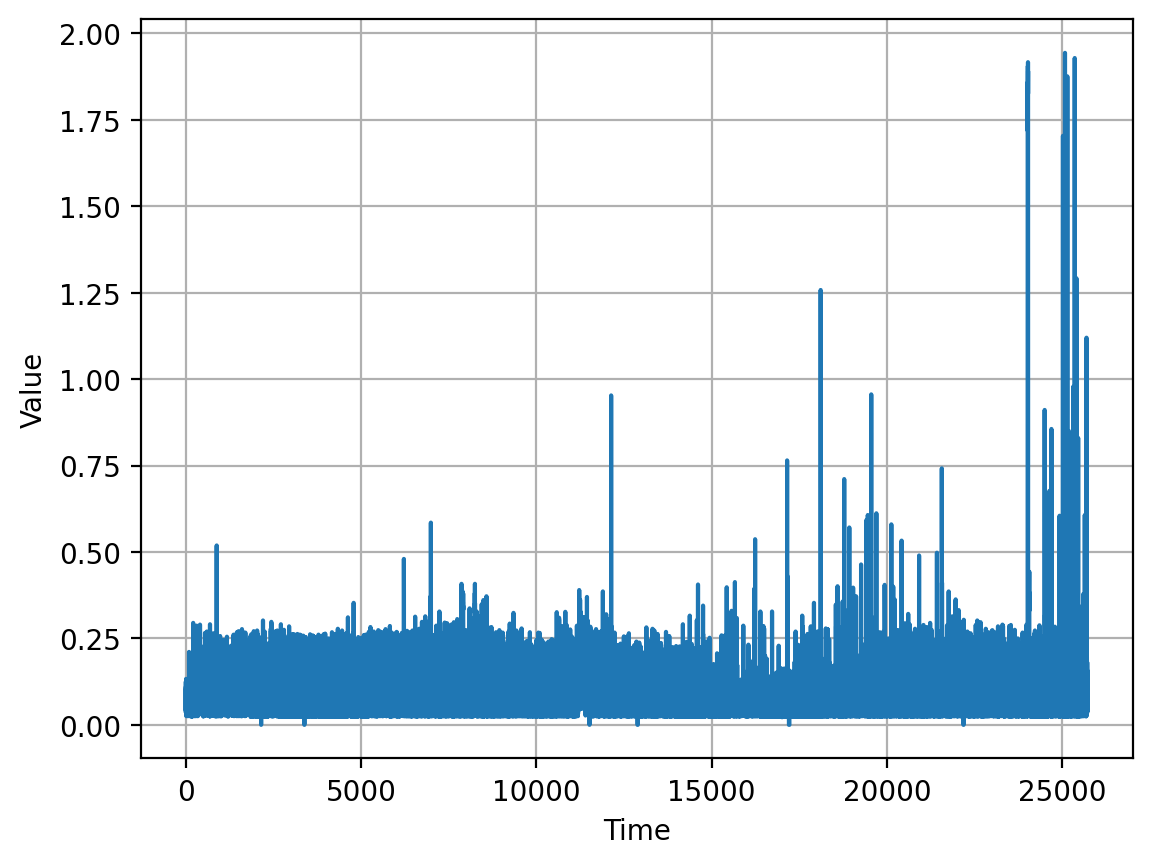

client  0


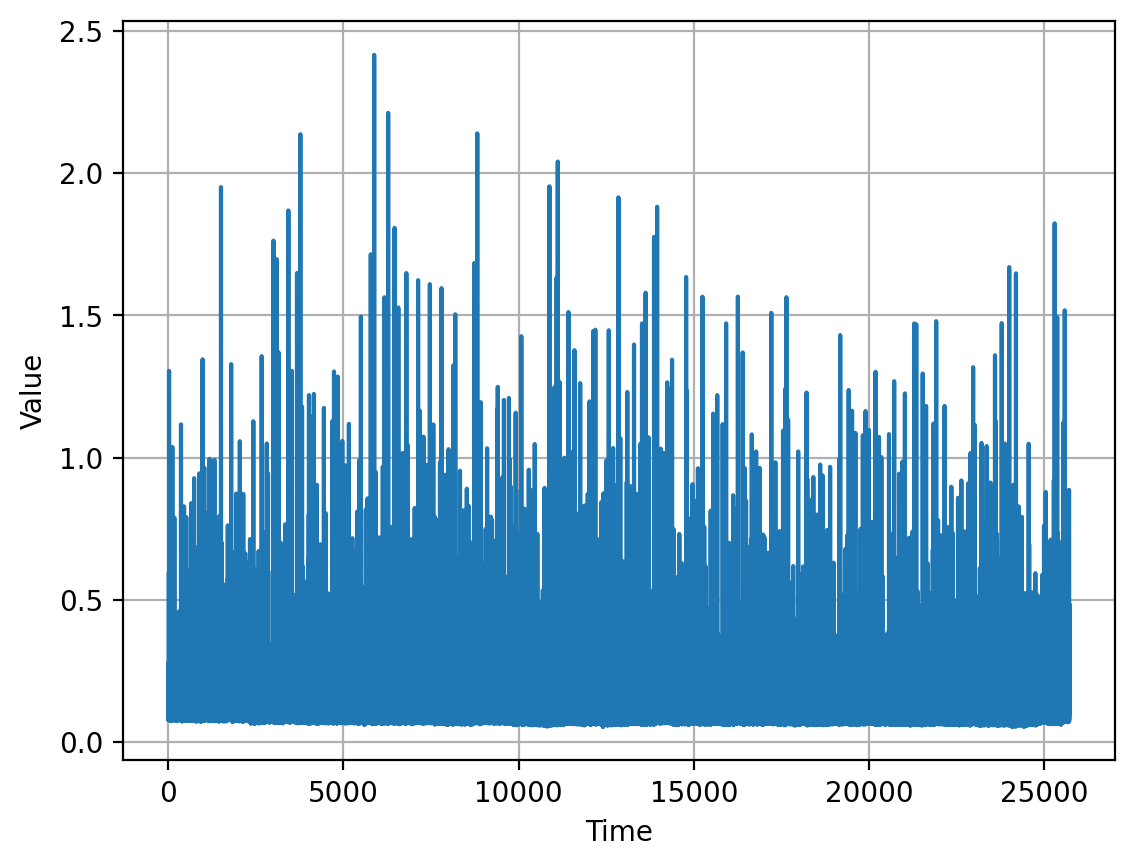

client  1


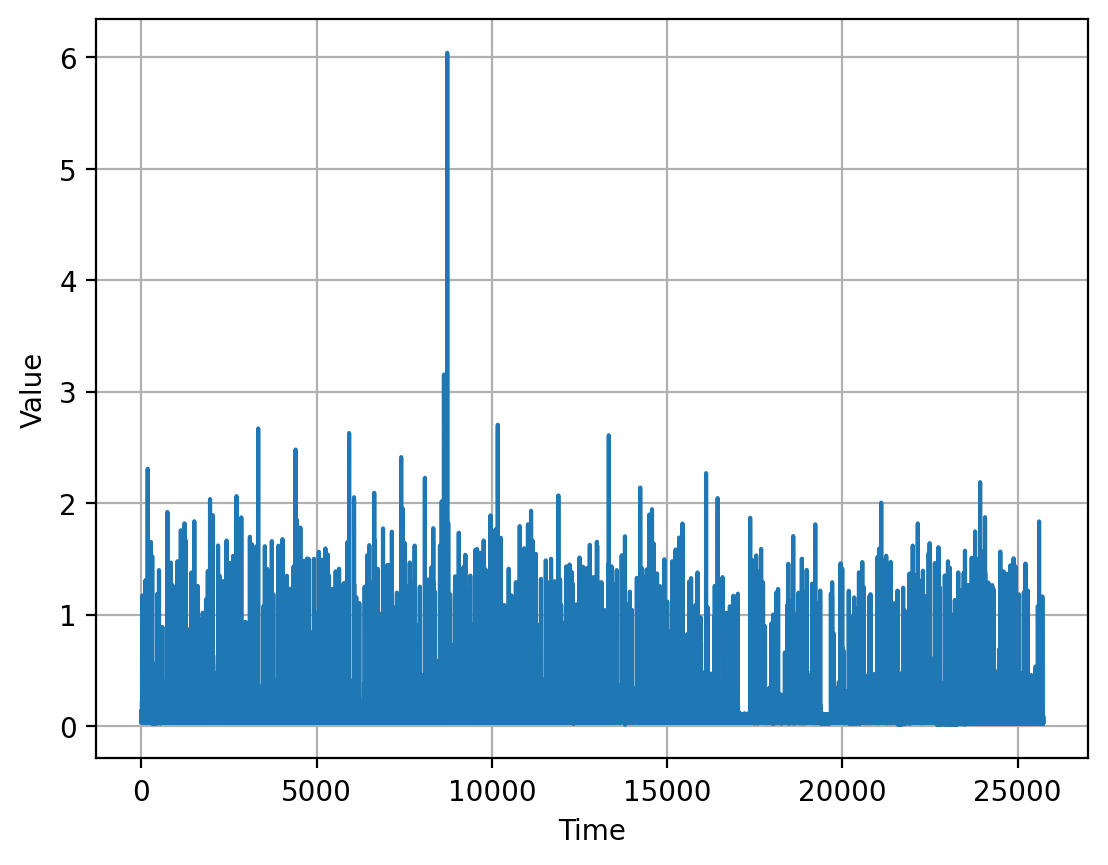

client  2


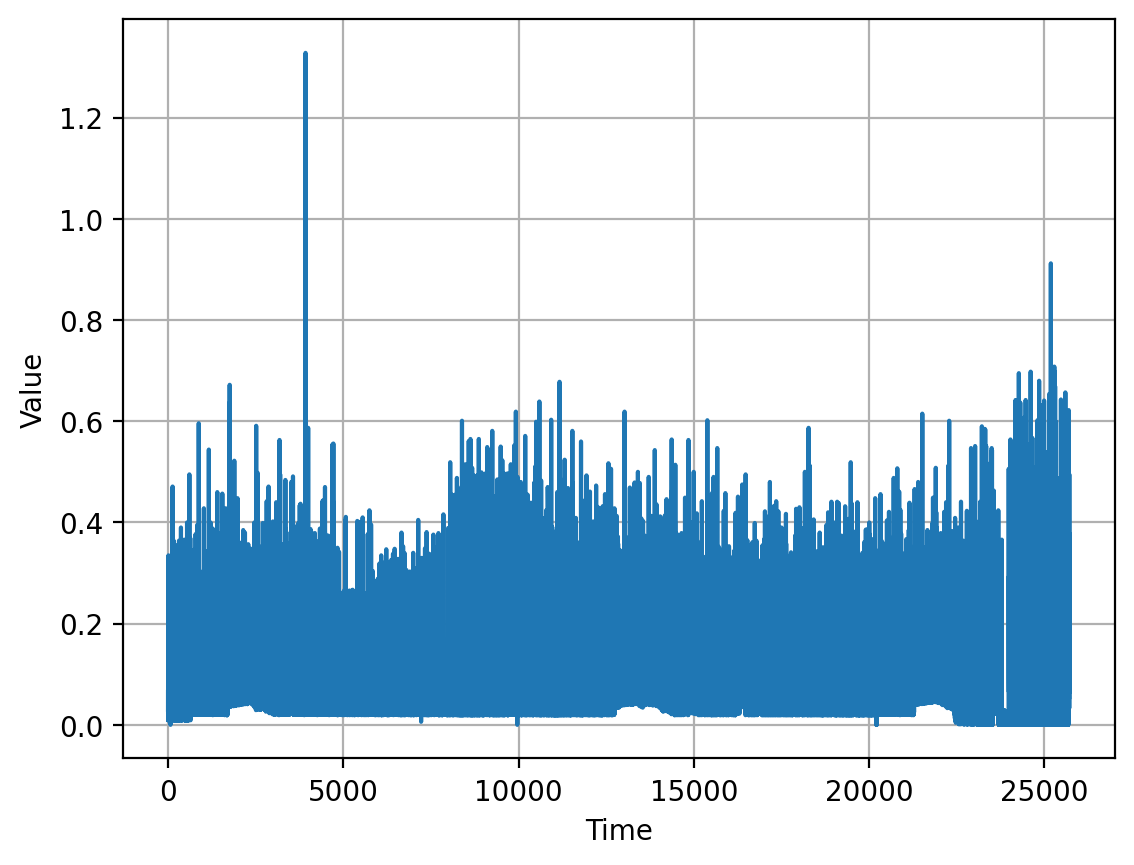

client  3


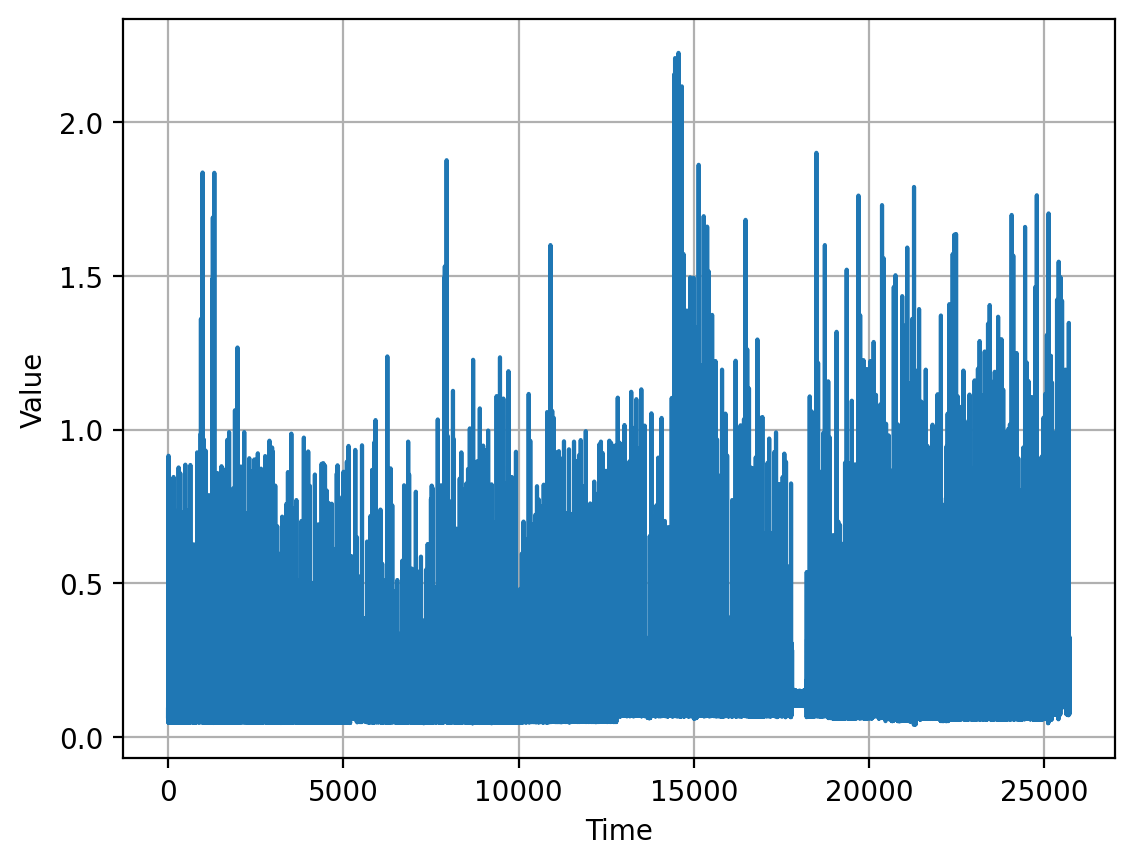

client  4


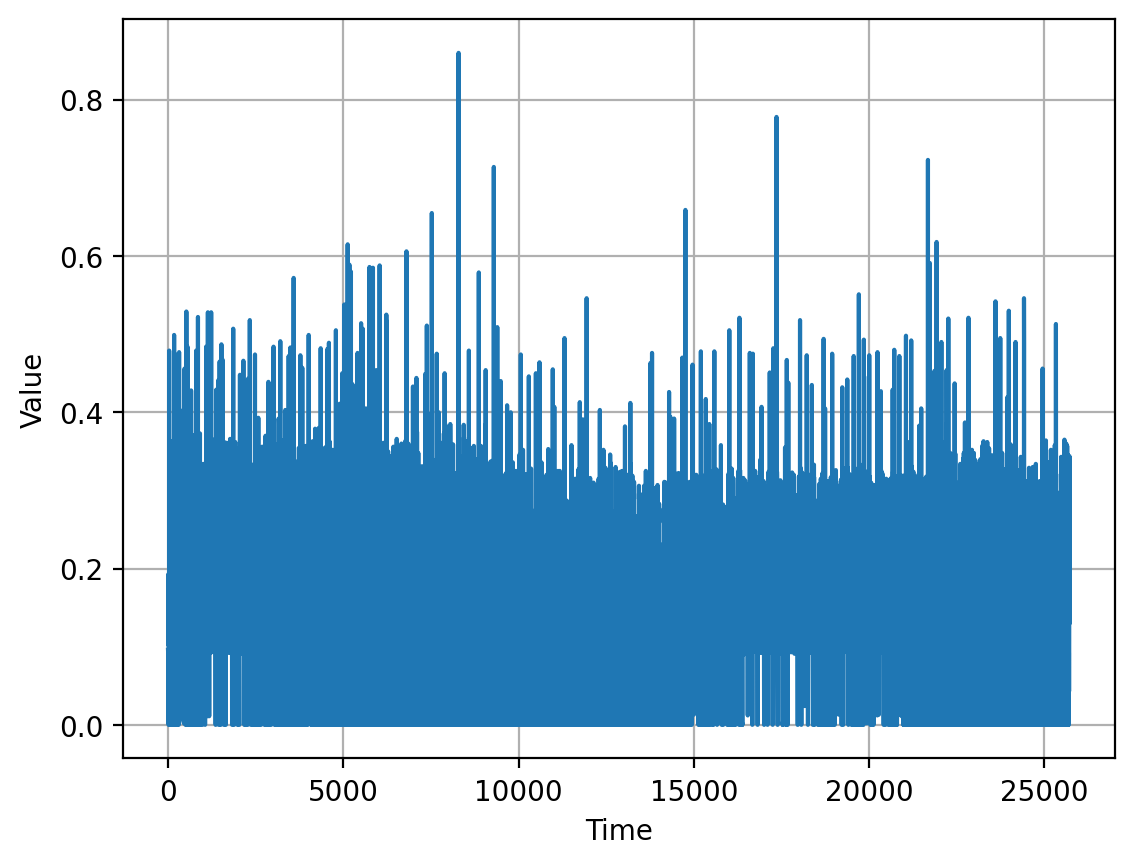

client  5


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/yi/anaconda3/envs/FLDL/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_26276/39578349.py", line 2, in <module>
    plot_series(range(0, len(consumption[0])), consumption[i])
  File "/tmp/ipykernel_26276/2901383999.py", line 2, in plot_series
    plt.plot(time[start:end], series[start:end], format, label=label, color=color)
  File "/home/yi/anaconda3/envs/FLDL/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2767, in plot
    return gca().plot(
  File "/home/yi/anaconda3/envs/FLDL/lib/python3.7/site-packages/matplotlib/pyplot.py", line 2272, in gca
    return gcf().gca(**kwargs)
  File "/home/yi/anaconda3/envs/FLDL/lib/python3.7/site-packages/matplotlib/figure.py", line 1567, in gca
    return self.add_subplot(1, 1, 1, **kwargs)
  File "/home/yi/anaconda3/envs/FLDL/lib/python3.7/site-packages/matplotlib/figure.py", lin

TypeError: object of type 'NoneType' has no len()

<Figure size 640x480 with 0 Axes>

In [9]:
for i in range(0, 30):
  plot_series(range(0, len(consumption[0])), consumption[i])
  plt.show()
  print('client {:2d}'.format(i))

  plt.clf()

In [ ]:
percentile = np.percentile(consumption, [0, 25, 50, 75, 100])
IQR = percentile[3] - percentile[1]
# increase the whisker to 3 instead of 1.5
UPL = percentile[3] + IQR*3
DNL = percentile[1] - IQR*3


In [ ]:
out_up = [0 for i in range(30)]
out_dn = [0 for i in range(30)]
for i in range(0, 30):
  for j in range(0, len(consumption[i])):
    if consumption[i][j] > UPL:
      consumption[i][j] = UPL
      out_up[i] = out_up[i] + 1
    elif consumption[i][j] < DNL:
      consumption[i][j] = DNL
      out_dn[i] = out_dn[i] + 1


# Create Training set

In [ ]:
length = len(date[0])
split = int(0.8*length)

train_raw = [x[0: split] for x in consumption]
test_raw = [x[split: ] for x in consumption]

In [ ]:
def create_dataset_central(data, time_step):
  x_data, y_data = [], []
  for i in range(len(data) - time_step):
    x = data[i: (i + time_step)]
    x_data.append(x)
    y = [data[i + time_step]]
    y_data.append(y)
  x_data = np.array(x_data)
  y_data = np.array(y_data)
  return x_data, y_data

In [ ]:
def create_dataset_fed(data, time_step):
  x_nest, y_nest = [], []
  for j in range(len(data)):
    x_data, y_data = [], []
    for i in range(len(data[j]) - time_step):
      x = data[j][i: (i + time_step)]
      x_data.append(x)
      y = [data[j][i + time_step]]
      y_data.append(y)

    x_data = np.array(x_data)[:, :, np.newaxis]
    x_nest.append(x_data)
    y_nest.append(y_data)
  x_nest = np.array(x_nest)  
  return [tf.data.Dataset.from_tensor_slices((x_nest[x], np.array(y_nest[x]))) for x in range(len(x_nest))]

In [ ]:
time_step = 48
train_data_fed = create_dataset_fed(train_raw, time_step)
test_data_fed = create_dataset_fed(test_raw, time_step)

In [ ]:
example_dataset = train_data_fed[0]
example_element = next(iter(example_dataset))

In [ ]:
num_epochs = 10
batch_size = 48
shuffle_buffer = 100
prefetch_buffer = 10

def preprocess_train(dataset):
  def batch_format_fn(x_d, y_d):
    return OrderedDict(
        x=x_d,
        y=tf.reshape(y_d, [-1, 1])
    )
  return dataset.repeat(num_epochs).shuffle(shuffle_buffer, seed=1).batch(
      batch_size).map(batch_format_fn).prefetch(prefetch_buffer)  

def preprocess_test(dataset):
  def batch_format_fn(x_d, y_d):
    return OrderedDict(
        x=x_d,
        y=tf.reshape(y_d, [-1, 1])
    )
  return dataset.batch(batch_size).map(batch_format_fn).prefetch(prefetch_buffer)

In [ ]:
preprocess_example = preprocess_train(example_dataset)

In [ ]:
train_set_fed = [preprocess_train(train_data_fed[i]) for i in range(len(train_raw))]
test_set_fed = [preprocess_test(test_data_fed[i]) for i in range(len(test_raw))]

train_set_central = train_set_fed[0]
test_set_central = test_set_fed[0]

# Train model

In [ ]:
def create_DNN():
  return tf.keras.models.Sequential([
      keras.layers.Dense(48, activation='relu',
      #input_dim = 48),either use Drop layer or regularizer                   
      input_dim = 48, kernel_regularizer='l2'),  
      keras.layers.Dropout(0.1),
      keras.layers.Dense(42, activation='relu'),
      keras.layers.Dropout(0.1),
      keras.layers.Dense(1)
  ])

In [ ]:
def model_fn():
  keras_model = create_DNN()
  return tff.learning.from_keras_model(
      keras_model,
      input_spec = preprocess_example.element_spec,
      loss = tf.keras.losses.MeanSquaredError(),
      metrics = [tf.keras.metrics.MeanSquaredError()]
  )

In [ ]:
iterative_process = tff.learning.build_federated_averaging_process(
    model_fn,
    client_optimizer_fn=lambda: keras.optimizers.Adam(0.001),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1)
)

logdir = "/tmp/logs/scalars/training"
summary_writer = tf.summary.create_file_writer(logdir)
state = iterative_process.initialize()

In [ ]:
num_rounds = 10
fed_metrics = [[] for i in range(0, num_rounds)]

start_time = time.time()
for i in range(0, num_rounds):
  state, metrics = iterative_process.next(state, train_set_fed)
  fed_metrics[i] = metrics
  print('round {:2d}, metrics={}'.format(i+1, metrics))

end_time = time.time()
train_time = end_time - start_time
print(train_time)

In [ ]:
evaluation = tff.learning.build_federated_evaluation(model_fn)
metrics = evaluation(state.model, test_set_fed)
print(metrics)

In [ ]:
model_fed = create_DNN()
state.model.assign_weights_to(model_fed)

use this model to predict on individual dataset directly, like the central model

In [ ]:
sample = tf.nest.map_structure(lambda x: x.numpy(), next(iter(test_set_fed[0])))

In [ ]:
prediciton_fed = model_fed.predict(sample['x'])


In [ ]:
print(f"MSE_fed: {mean_squared_error(prediciton_fed, sample['y'])}")
print(f"R2_fed: {r2_score(sample['y'], prediciton_fed)}")

In [ ]:
time_plot = range(0, 48)
plt.figure(figsize=(10, 6))
plot_series(time_plot, prediciton_fed, color='red')
plot_series(time_plot, sample['y'])

## Centralized Models

In [ ]:
x_central, y_central = create_dataset_central(train_raw[0], time_step)
x_test, y_test = create_dataset_central(test_raw[0], time_step)

In [ ]:
model_central = create_DNN()
adam = keras.optimizers.Adam(learning_rate=0.001)
model_central.compile(loss='mse', optimizer=adam, metrics=['mse'])

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
model_central.fit(
   x=x_central,
   y=y_central,
   batch_size=batch_size,
   epochs=500,
   callbacks=[callback],
   shuffle=True,
   verbose=0,
)

In [ ]:
a = model_central.predict(x_test)

In [ ]:
print(f"MSE: {mean_squared_error(a, y_test)}")
print(f"R2: {r2_score(y_test, a)}")

In [ ]:
prediction_central = a[0:48]


In [ ]:
print(f"MSE_central: {mean_squared_error(prediction_central, y_test[0:48])}")
print(f"R2_central: {r2_score(y_test[0:48], prediction_central)}")

In [ ]:
time_plot = range(0, 48)
plt.figure(figsize=(10, 6))
plot_series(time_plot, prediction_central, color='red')
plot_series(time_plot, y_test[0:48])

In [ ]:
time_plot = range(0, 48)
plt.figure(figsize=(10, 6))
plot_series(time_plot, prediciton_fed, color='red')
plot_series(time_plot, prediction_central)

# 30 self-trained DNN

In [ ]:
xx = [[] for i in range(30)]
yy = [[] for i in range(30)]
xx_test = [[] for i in range(30)]
yy_test = [[] for i in range(30)]

for i in range(0, 30):
  xx[i], yy[i] = create_dataset_central(train_raw[i], time_step)
  xx_test[i], yy_test[i] = create_dataset_central(test_raw[i], time_step)
  

In [ ]:
def model_loop(train, target, test):
  model_l = create_DNN()
  adam = keras.optimizers.Adam(learning_rate=0.001)
  model_l.compile(loss='mse', optimizer=adam, metrics=['mse'])
  callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)
  model_l.fit(
   x=train,
   y=target,
   batch_size=batch_size,
   epochs=500,
   callbacks=[callback],
   shuffle=True,
   verbose=0,)
  return model_l.predict(test)

In [ ]:
l = [[] for i in range(30)]
MSE_cen = [[] for i in range(30)]
R2_cen = [[] for i in range(30)]

start_time = time.time()

for i in range(0, 30):
  l[i] = model_loop(xx[i], yy[i], xx_test[i])
  MSE_cen[i] = mean_squared_error(yy_test[i], l[i])
  R2_cen[i] = r2_score(yy_test[i], l[i])
  print('client {:2d}, metrics={}'.format(i , MSE_cen[i]))

end_time = time.time()
train_time_cen = end_time - start_time
print(train_time_cen)

In [ ]:
print("average MSE:", np.mean(MSE_cen))

In [ ]:
print("average MSE:", np.mean(MSE_cen))
worst = max(MSE_cen)
worst_id = MSE_cen.index(worst)
print("worst performance self model:", worst_id, "|| MSE = ", worst)
best = min(MSE_cen)
best_id = MSE_cen.index(best)
print("best performance self model:", best_id, "|| MSE = ", best)

# worst

In [ ]:
predict_worst = l[worst_id][0:48]
plt.figure(figsize=(10, 6))
plot_series(time_plot, predict_worst, color='red')
plot_series(time_plot, yy_test[worst_id][0:48])

In [ ]:
predict_fed_worst = model_fed.predict(xx_test[worst_id])
print(f"MSE_fed: {mean_squared_error(predict_fed_worst, yy_test[worst_id])}")
print(f"R2_fed: {r2_score(yy_test[worst_id], predict_fed_worst)}")

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_plot, predict_fed_worst[0:48], color='green')
plot_series(time_plot, predict_worst, color='red')
plot_series(time_plot, yy_test[worst_id][0:48])

In [ ]:
sample_worst_week = consumption[worst_id][48*7*30: 48*7*31]
plot_series(range(len(sample_worst_week)), sample_worst_week)
plt.show()
plt.clf()
sample_worst_3day = consumption[worst_id][48*3*100: 48*3*101]
plot_series(range(len(sample_worst_3day)), sample_worst_3day)



In [ ]:
plot_series(range(len(consumption[worst_id])), consumption[worst_id])


# Best

In [ ]:
predict_best = l[best_id][0:48]
plt.figure(figsize=(10, 6))
plot_series(time_plot, predict_best, color='red')
plot_series(time_plot, yy_test[best_id][0:48])

In [ ]:
predict_fed_best = model_fed.predict(xx_test[best_id])
print(f"MSE_fed: {mean_squared_error(predict_fed_best, yy_test[best_id])}")
print(f"R2_fed: {r2_score(yy_test[best_id], predict_fed_best)}")

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_plot, predict_fed_best[0:48], color='red')
plot_series(time_plot, predict_best)

In [ ]:
sample_15_week = consumption[best_id][48*7*30: 48*7*31]
plot_series(range(len(sample_15_week)), sample_15_week)
plt.show()
plt.clf()
sample_15_3day = consumption[best_id][48*3*100: 48*3*101]
plot_series(range(len(sample_15_3day)), sample_15_3day)

